# GE Attribution Challenge: Sandbox
This notebook, although full of components that inform the main/final model, is just a sandbox
where I tried several approaches in a (as you can see if you attempt to parse through it) haphazard
manner. This led to the notebook becoming quite disorganized. This was a learning experience and I'm 
working on standardizing some process for doing this variety of work. It exists only for the purpose of 
retaining all documentation, and it should not be recognized as a finished product in any capacity.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import permutations
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

In [2]:
X = pd.read_csv("train_values.csv")
y = pd.read_csv("train_labels.csv")

Just to be sure that each `sequence_id` has only one origin, the congruence of the one-hot encoded sums will be checked agains the number of rows of the dataset

In [3]:
y_sums = y.sum(axis=1).values
sum(y_sums) == y.shape[0]

True

The training labels need to be collapsed from their sparse matrix format

In [3]:
lab_ids = y.columns[1:]
# get numpy matrix of lab_id one-hot values
lab_matrix = y.drop(columns=['sequence_id']).values
# get array of indices to map back to lab_ids
lab_col_indices = np.asarray(lab_matrix == 1).nonzero()[1]

y['lab_id'] = lab_ids[lab_col_indices]
lbls = y
y = y[['sequence_id', 'lab_id']]

In [5]:
# verify that all labels are correct
def correct_label(row_n):
    return lbls.iloc[row_n][lbls['lab_id'].iloc[row_n]] == 1

assert all(list(map(correct_label, range(lbls.shape[0]))))

In [4]:
# what are the proportions of the classes?
y['lab_id'].value_counts(normalize=True).head()

I7FXTVDP    0.131488
RKJHZGDQ    0.043353
GTVTUGVY    0.042401
A18S09P2    0.016884
Q2K8NHZY    0.015440
Name: lab_id, dtype: float64

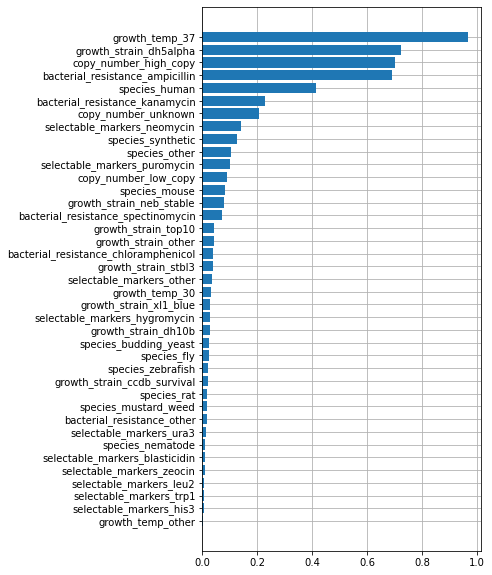

In [47]:
# what are the most prevalent binary features?
column_names = X.iloc[:, 2:].mean().sort_values(ascending=True).index
feature_props = X.iloc[:, 2:].mean().sort_values(ascending=True).values

plt.figure(figsize=(5, 10))
plt.grid(b=True)
plt.barh(np.arange(len(column_names)), feature_props, zorder=2)
plt.yticks(range(len(column_names)), labels=column_names)
plt.show()

Cross validation would be a useful technique, but there are classes where there are less than 5 members. we'll try to over-sample the underrepresented classes

In [5]:
# these are the classes with less than 5 members
# need all to have at least 5 for randomized search cv
print(y['lab_id'].value_counts().tail(19))

# create resampling map
resample_map = y['lab_id'].value_counts().tail(19)
resample_map = list(zip(resample_map.index, resample_map.values))

03GRNN7N    4
1KZHNVYR    4
8N5EPD5C    4
WM3Q8LBC    4
LGTP4O86    4
PXT3AJ7C    4
W2DYAZID    4
YCD71LRY    4
68OY1RK5    4
INDCDVP0    4
UMOD7PGG    4
VDSDXJ71    4
RZPGGEG4    4
XCWSW5T9    4
58BSUZQB    3
G2P73NZ0    3
WB78G3XF    2
ON9AXMKF    1
0L3Y6ZB2    1
Name: lab_id, dtype: int64


In order to oversample the underrepresented classes, we need to add the lab id's back into the feature matrix

In [6]:
over_samp = pd.concat([X, y['lab_id']], axis=1)
over_samp.head()

,sequence_id,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,...,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish,lab_id
0,9ZIMC,CATGCATTAGTTATTAATAGTAATCAATTACGGGGTCATTAGTTCA...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,RYUA3GVO
1,5SAQC,GCTGGATGGTTTGGGACATGTGCAGCCCCGTCTCTGTATGGAGTGA...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,RYUA3GVO
2,E7QRO,NNCCGGGCTGTAGCTACACAGGGCGGAGATGAGAGCCCTACGAAAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,RYUA3GVO
3,CT5FP,GCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGCAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,RYUA3GVO
4,7PTD8,CGCGCATTACTTCACATGGTCCTCAAGGGTAACATGAAAGTGATCC...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,RYUA3GVO


In [7]:
def oversample(df, resamp_map, min_samps=5):
    """
    Randomly oversample rows that belong to classes with less than N
    members
    
    df: pandas DataFrame object
    resamp_map: reference values for classes and resample amount
    """
    new_df = df.copy()
    for class_, members in resamp_map:
        for i in range(min_samps - members):
            new_row = new_df.loc[new_df['lab_id'] == class_].sample(n=1)
            new_df = new_df.append(new_row)
    
    return new_df

Now the minimum number of members for each class is 5

In [8]:
over_samp = oversample(over_samp, resample_map)
over_samp['lab_id'].value_counts().tail(20)

1LBGAU5Z    5
LUI0TOT2    5
3EARN0Z7    5
QNE79S52    5
KD7N9YDF    5
UYLJZRPN    5
HGN5HD65    5
78XDAJNS    5
Z7YFK3I0    5
G6MP6EIN    5
VMU0L6UM    5
RZPGGEG4    5
TI21BGNU    5
XCWSW5T9    5
2L336TQL    5
WB78G3XF    5
DJW5U56I    5
BV6PVSO5    5
QYBCIW4J    5
5Z4CMIY5    5
Name: lab_id, dtype: int64

The plan is to extract 4-grams using raw counts from the sequences and concatenate the resulting 
features to the existing binary features. From there the prospective model can fit the entire data
set.

In [9]:
N_GRAMS = 4

# create the 'vocabulary' for the different nucleotides
n_tides = set(''.join(over_samp['sequence'].values))

# create a list of subsequences for features
subseqs = list(''.join(p) for p in permutations(n_tides, r=N_GRAMS))
subseqs[:5]

['AGNT', 'AGNC', 'AGTN', 'AGTC', 'AGCN']

In [10]:
def seq_table(data, seqs):
    """Creates a dataframe based on nucleotide subsequence counts"""
    table = pd.DataFrame(index=data.index)
    for s in seqs:
        table[s] = data['sequence'].str.count(s)
    return table

At this point, I have tried several approaches, all with fair results:
- Nearest neighbors classifier on all the features with cross-validated randomized search (produced best score so far)
- Support vector machine on all features
- Permutation importance based on a decision tree classifier, who's output was then used to narrow down the most important features (this hurt both the svm score and the nnc score

The last idea I'll try in this sandbox before closing up shop and settling on a method is the following:
- Separate the data into two groups, the one-hot encoded features and the vectorized sequences.
- Treat the tokenized sequences like a natural language processing problem and use TFIDF to vectorize (as opposed to the raw counts + scaling that I tried before)
- Use a NNC on the sequences and the best estimator on the one-hot encoded data, then aggregate the probability estimates by taking a mean of the two probability tables

In [ ]:
# skipped the concatenation for the dual model method
ngrams = seq_table(over_samp, subseqs)

# concatenate the new dataframe to the existing one
X = pd.concat([over_samp, ngrams], axis=1).drop(columns=['sequence'])
X.head()

In [12]:
ngrams = seq_table(over_samp, subseqs)
ngrams.head()

,AGNT,AGNC,AGTN,AGTC,AGCN,AGCT,ANGT,ANGC,ANTG,ANTC,...,CNGA,CNGT,CNTA,CNTG,CTAG,CTAN,CTGA,CTGN,CTNA,CTNG
0,0,0,0,25,0,39,0,0,0,0,...,0,0,0,0,13,0,44,0,0,0
1,0,0,0,2,0,2,0,0,0,0,...,0,0,0,0,1,0,6,0,0,0
2,0,0,0,0,0,3,0,1,0,0,...,0,0,0,0,0,0,2,2,0,0
3,0,0,0,6,0,2,0,0,0,0,...,0,0,0,0,6,0,8,0,0,0
4,0,0,0,3,0,5,0,1,0,0,...,0,0,0,0,2,0,4,0,0,0


The new data needs to be normalized because of the different scales (binary and counts)

In [13]:
# two separate training and validation sets need to be created
# one based on the ngrams and another on just one-hot

tfidf = TfidfTransformer()
ngrams_tfidf = tfidf.fit_transform(ngrams)

le = LabelEncoder()

# set y first and encode
y = over_samp['lab_id']
y = le.fit_transform(y)

# set X_normalized and convert to compressed sparse matrix
X = over_samp.drop(columns=['lab_id'])

# save the column names for use in permutation importance
column_names = X.iloc[:, 1:].columns
one_hot = X.iloc[:, 2:]

In [14]:
Xoh_train, Xoh_val, yoh_train, yoh_val = train_test_split(one_hot, y, 
                                                  test_size=.20, 
                                                  random_state=0, 
                                                  stratify=y)

Xgr_train, Xgr_val, ygr_train, ygr_val = train_test_split(ngrams_tfidf, y, 
                                                  test_size=.20, 
                                                  random_state=0, 
                                                  stratify=y)
print(Xoh_train.shape, Xoh_val.shape)
print(yoh_train.shape, yoh_val.shape)
print(Xgr_train.shape, Xgr_val.shape)
print(ygr_train.shape, ygr_val.shape)

(50436, 39) (12610, 39)
(50436,) (12610,)
(50436, 120) (12610, 120)
(50436,) (12610,)


In [48]:
le = LabelEncoder()

# set y first and encode
y = X['lab_id']
y = le.fit_transform(y)

# set X_normalized and convert to compressed sparse matrix
X = X.drop(columns=['lab_id'])

# save the column names for use in permutation importance
column_names = X.iloc[:, 1:].columns
X_normalized = normalize(X.iloc[:, 1:])

In [ ]:
# construct decision tree classifier with random search
dtc = DecisionTreeClassifier(random_state=0)

params = {"criterion": ["gini", "entropy"],
          "splitter": ["best", "random"],
          "max_depth": range(2,20),
          "min_samples_leaf": range(1, 20)}
rs = RandomizedSearchCV(dtc, params, random_state=0, verbose=1, n_jobs=-1, n_iter=5)
search = rs.fit(X_normalized, y)

In [32]:
# contruct rfc with random search
rfc = RandomForestClassifier(random_state=0)

params = {"n_estimators": range(50, 150, 25),
          "criterion": ["gini", "entropy"],
          "max_depth": range(5, 20, 5),
          "min_samples_leaf": range(1, 10),
          "max_features": ["sqrt", "log2"]}

rs = RandomizedSearchCV(rfc, params, random_state=0, verbose=1, n_jobs=-1, n_iter=5)
search = rs.fit(one_hot, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.5min finished


In [34]:
search.best_estimator_

RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=3,
                       random_state=0)

In [49]:
nnc = KNeighborsClassifier(algorithm='brute', metric='cosine', n_neighbors=30,
                           weights='distance')
nnc.fit(Xgr_train, ygr_train)

KNeighborsClassifier(algorithm='brute', metric='cosine', n_neighbors=30,
                     weights='distance')

In [50]:
nnc.score(Xgr_val, ygr_val)

0.5917525773195876

In [88]:
# construct the neighbors model
nn_classifier = KNeighborsClassifier(algorithm="brute", metric="cosine", leaf_size=40)

params = {"n_neighbors": range(1,40),
          "weights": ["uniform", "distance"],
          "leaf_size": range(20, 50, 10)}

clf = RandomizedSearchCV(nn_classifier, params, random_state=0, 
                         verbose=1, n_jobs=3, n_iter=5)
search = clf.fit(ngrams_tfidf, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed: 12.1min finished


In [94]:
best_nnc = search.best_estimator_

In [58]:
X_normalized.shape

(63046, 159)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_normalized, y, 
                                                  test_size=.20, 
                                                  random_state=0, 
                                                  stratify=y)
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(50436, 159) (12610, 159)
(50436,) (12610,)


In [85]:
decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=66, random_state=0)
decision_tree.fit(Xgr_train, ygr_train)

DecisionTreeClassifier(criterion='entropy', max_depth=66, random_state=0)

In [84]:
decision_tree.score(Xgr_val, ygr_val)

0.4212529738302934

In [36]:
nn_classifier = KNeighborsClassifier(weights="distance", algorithm="kd_tree",
                                     metric="manhattan", leaf_size=30, p=1, n_neighbors=30)
nn_classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', metric='manhattan', n_neighbors=30,
                     p=1, weights='distance')

In [16]:
def top10_accuracy(estimator, X, y):
    """
    Custom scorer based on competition function.
    Evaluation is based on whether the right label
    is in the top 10 most probable predictions. 
    Adheres to the signature in sklearn documentation
    for scorers
    """
    # get probabilities
    probs = estimator.predict_proba(X)
    
    # get indices for top 10
    top10_idx = np.argpartition(probs, -10, axis=1)[:, -10:]
    
    # get the class names
    top10_preds = estimator.classes_[top10_idx]
    
    # check if correct label is in top 10 for each set of preds
    mask = top10_preds == y.values.ravel().reshape((y.size, 1))
    
    # get the mean
    top_10_accuracy = mask.any(axis=1).mean()
    
    return top_10_accuracy

In order to reduce model variance and hopefully increase accuracy via better generalization, we'll use permutation importance to narrow down the the most important features

In [19]:
result = permutation_importance(decision_tree, X_train, y_train, random_state=0, n_repeats=3)

In [20]:
TOP = 40
feature_names = X.iloc[:, 1:].columns
importances = result.importances_mean

feature_importances = pd.DataFrame({"feature": feature_names,
                                    "importance": importances})
length = feature_importances.shape[0]
feature_importances = feature_importances.sort_values(by='importance').iloc[length-TOP:length]
most_important = feature_importances["feature"]

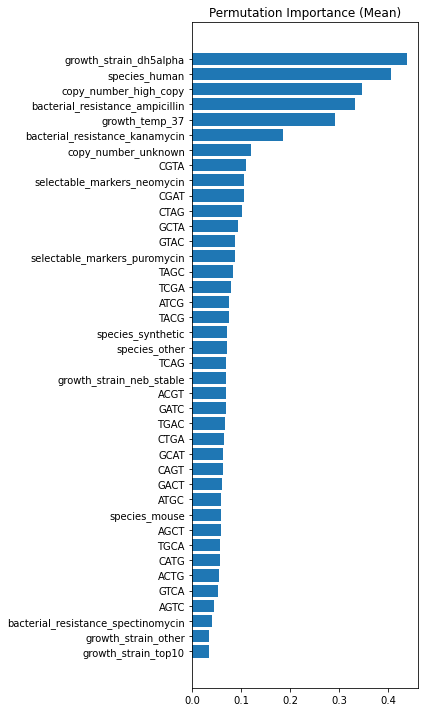

In [21]:
# plot feature importances
y_ticks = np.arange(0, feature_importances.shape[0])
fig, ax = plt.subplots(figsize=(6, 10))

ax.barh(y_ticks,feature_importances["importance"].values)
ax.set_yticklabels(feature_importances["feature"].values)
ax.set_yticks(y_ticks)
ax.set_title("Permutation Importance (Mean)")
fig.tight_layout()
plt.show()

### Post-Permutation Importance

In [22]:
X = X[most_important]
X_normalized = normalize(X)

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X_normalized, y, 
                                                  test_size=.20, 
                                                  random_state=0, 
                                                  stratify=y)
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(50436, 159) (12610, 159)
(50436,) (12610,)


In [ ]:
# construct svm model with Randomized search
svm_clf = SVC(cache_size=1000)

params = {"C": [.1, 1, 10, 100, 1000,
                10000, 10000, 1000000,
                10000000, 100000000, 1000000000, 10000000000],
          "gamma": [1e-09, 1e-08, 1e-07,
                    1e-06, 1e-05, .0001,
                    .001, .01, .1, 1]}
rscv = RandomizedSearchCV(svm_clf, params, random_state=0, verbose=1, n_jobs=3, n_iter=5)
search = rscv.fit(one_hot, y)

In [157]:
search.best_params_

{'gamma': 0.01, 'C': 100000000}

In [158]:
search.best_estimator_.score(X_val, y_val)

0.959238699444885

In [50]:
svm = SVC(probability=True, cache_size=2000, 
          gamma=0.01, C=100000000)
svm.fit(X_train, y_train)

SVC(C=100000000, cache_size=2000, gamma=0.01, probability=True)

In [37]:
nn_classifier.score(X_val, y_val)

0.6068199841395717

In [51]:
svm.score(X_val, y_val)

0.654639175257732

In [49]:
top10_accuracy(nn_classifier, X_val, y_val) # 20 n

0.8547184773988897

In [51]:
top10_accuracy(nn_classifier, X_val, y_val) # 10 n

0.8340206185567011

In [53]:
top10_accuracy(nn_classifier, X_val, y_val) # 30 n

0.86050753370341

In [27]:
X_test = pd.read_csv("test_values.csv")

# convert sequences to features
test_ngrams = seq_table(X_test, subseqs)
# concatenate new features
X_test = pd.concat([X_test, test_ngrams], axis=1)[most_important]
# normalize
X_test_normalized = normalize(X_test)

In [28]:
svm_probs = svm.predict_proba(X_test_normalized)

In [55]:
probs = nn_classifier.predict_proba(X_test_normalized)

In [37]:
randomf = search.best_estimator_

In [39]:
# format testing data
test = pd.read_csv("test_values.csv")

# split sequences and one-hot encoded
test_ngrams = seq_table(test, subseqs)
test_ngrams = tfidf.transform(test_ngrams)

test_one_hot = test.drop(columns=["sequence", "sequence_id"])

In [46]:
test_ngrams.shape

(18816, 120)

In [51]:
rfc_probs = randomf.predict_proba(test_one_hot)
nn_probs = nnc.predict_proba(test_ngrams)

In [58]:
agg_probs = (nn_probs + rfc_probs) / 2

In [59]:
agg_probs

array([[1.31069239e-05, 5.44164502e-05, 0.00000000e+00, ...,
        1.10083664e-06, 1.27601867e-05, 2.15018071e-02],
       [1.80686360e-05, 5.82987569e-05, 4.04895967e-06, ...,
        7.17153457e-03, 2.81864818e-07, 9.21572315e-05],
       [1.53080347e-05, 1.40969581e-04, 1.50575120e-05, ...,
        2.77735964e-06, 5.31258020e-05, 1.25535302e-02],
       ...,
       [7.75263520e-05, 5.15043834e-04, 8.26831142e-05, ...,
        4.73701202e-02, 2.81864818e-07, 1.08686038e-04],
       [1.08669353e-04, 7.04941798e-04, 1.09428033e-04, ...,
        2.15984639e-03, 2.81864818e-07, 1.11492319e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 5.19585839e-05]])

In [32]:
le.classes_

array(['00Q4V31T', '012VT4JK', '028IO5W2', ..., 'ZWFD8OHC', 'ZX06ZDZN',
       'ZZJVE4HO'], dtype=object)

In [61]:
sub_format = pd.read_csv("submission_format_3TFRxH6.csv", index_col='sequence_id')

# assert sub_format.shape == probs.shape
# assert (nn_classifier.classes_ == sub_format.columns).all()

assert sub_format.shape == agg_probs.shape
assert (le.classes_ == sub_format.columns).all()

In [62]:
# submission = pd.DataFrame(data=probs, 
#                           columns=nn_classifier.classes_,
#                           index=sub_format.index)

# svm_submission = pd.DataFrame(data=svm_probs, 
#                           columns=le.classes_,
#                           index=sub_format.index)

agg_submission = pd.DataFrame(data=agg_probs, 
                          columns=le.classes_,
                          index=sub_format.index)

In [64]:
agg_submission.to_csv("agg_submission.csv")